In [1]:
import torch

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


In [3]:
# Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST normalization
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Image shape: {train_dataset[0][0].shape}")

Training samples: 60000
Test samples: 10000
Batch size: 128
Image shape: torch.Size([1, 28, 28])


In [ ]:
class LinearAutoencoder(nn.Module):
    """
    Simple autoencoder using only linear layers for MNIST.
    Compresses 28x28=784 pixel images to a lower dimensional bottleneck.
    """
    def __init__(self, input_dim=784, hidden_dims=[512, 256, 128], latent_dim=64):
        super(LinearAutoencoder, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        # Encoder layers
        encoder_layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        
        # Final encoder layer to latent space
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))
        
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder layers (mirror of encoder)
        decoder_layers = []
        prev_dim = latent_dim
        
        # Reverse the hidden dimensions for decoder
        reversed_hidden_dims = list(reversed(hidden_dims))
        
        for hidden_dim in reversed_hidden_dims:
            decoder_layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        
        # Final decoder layer to reconstruct input
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        # No activation on final layer - we'll apply sigmoid in forward pass
        
        self.decoder = nn.Sequential(*decoder_layers)
    
    def encode(self, x):
        """Encode input to latent representation"""
        x = x.view(x.size(0), -1)  # Flatten image
        return self.encoder(x)
    
    def decode(self, z):
        """Decode latent representation to reconstruction"""
        x = self.decoder(z)
        return torch.sigmoid(x)  # Sigmoid to get values in [0,1] range
    
    def forward(self, x):
        """Full forward pass: encode then decode"""
        z = self.encode(x)
        
        e_s = torch.sigmoid(z)
        # q is copy of e_s
        q = e_s.clone()
        q[e_s > 0.5] = 1.0
        q[e_s <= 0.5] = 0.0
        q = e_s + (q - e_s).detach()  # Detach to avoid gradients flowing back to e_s
        l_commit = (q - e_s).pow(2).mean()  # Commitment loss

        x_recon = self.decode(q)

        # to do do resedual like rvq with the output
        return x_recon, q, l_commit
    
    def get_compression_ratio(self):
        """Calculate compression ratio"""
        return self.input_dim / self.latent_dim

In [5]:
# Create model
model = LinearAutoencoder(
    input_dim=784,  # 28*28
    hidden_dims=[512, 256, 128],
    latent_dim=8  # Compress to 32 dimensions
).to(device)

# Print model information
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Compression ratio: {model.get_compression_ratio():.1f}:1")

Model Architecture:
LinearAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=512, out_features=784, bias=True)
  )
)

Total 

In [6]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        recon_data, latent, lc = model(data)
        
        # Flatten original data for loss calculation
        data_flat = data.view(data.size(0), -1)
        
        # Calculate reconstruction loss
        loss = criterion(recon_data, data_flat) + lc *0.01
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}: Loss: {loss.item():.6f}')
    
    return total_loss / len(train_loader)

def evaluate(model, test_loader, criterion, device):
    """Evaluate the model on test set"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            
            # Forward pass
            recon_data, latent, lc = model(data)
            
            # Flatten original data for loss calculation
            data_flat = data.view(data.size(0), -1)
            
            # Calculate reconstruction loss
            loss = criterion(recon_data, data_flat)
            total_loss += loss.item()
    
    return total_loss / len(test_loader)

# Setup training
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

print("Training setup complete!")

Training setup complete!


In [7]:
input_sample, _ = next(iter(train_loader))
e = model.encode(input_sample.to(device))
e_s = torch.sigmoid(e)
# q is copy of e_s
q = e_s.clone()
q[e_s > 0.5] = 1.0
q[e_s <= 0.5] = 0.0
q = e_s + (q - e_s).detach()  # Detach to avoid gradients flowing back to e_s
l_commit = (q - e_s).pow(2).mean()  # Commitment loss

In [8]:
e_s

tensor([[0.5340, 0.4981, 0.4884,  ..., 0.5106, 0.4644, 0.5108],
        [0.5321, 0.4956, 0.4979,  ..., 0.5029, 0.4782, 0.5120],
        [0.5079, 0.4801, 0.4908,  ..., 0.5011, 0.4742, 0.4950],
        ...,
        [0.5342, 0.4903, 0.4963,  ..., 0.4953, 0.4685, 0.4915],
        [0.5360, 0.4954, 0.5215,  ..., 0.5130, 0.4686, 0.5142],
        [0.5406, 0.4683, 0.4945,  ..., 0.5238, 0.4640, 0.4845]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [9]:
# Training loop
num_epochs = 20
train_losses = []
test_losses = []

print("Starting training...")
print("-" * 60)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 40)
    
    # Train for one epoch
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    
    # Evaluate on test set
    test_loss = evaluate(model, test_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(test_loss)
    
    # Store losses
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    # Print epoch summary
    current_lr = optimizer.param_groups[0]['lr']
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"Train Loss: {train_loss:.6f}")
    print(f"Test Loss: {test_loss:.6f}")
    print(f"Learning Rate: {current_lr:.2e}")

print("\nTraining completed!")

# Plot training curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Train Loss', linewidth=2)
plt.plot(range(1, num_epochs + 1), test_losses, 'r-', label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Train Loss', linewidth=2)
plt.plot(range(1, num_epochs + 1), test_losses, 'r-', label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Test Loss (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Starting training...
------------------------------------------------------------

Epoch 1/20
----------------------------------------
Batch 0/469: Loss: 1.249898
Batch 0/469: Loss: 1.249898
Batch 100/469: Loss: 0.789791
Batch 100/469: Loss: 0.789791
Batch 200/469: Loss: 0.806323
Batch 200/469: Loss: 0.806323
Batch 300/469: Loss: 0.797294
Batch 300/469: Loss: 0.797294
Batch 400/469: Loss: 0.799143
Batch 400/469: Loss: 0.799143

Epoch 1 Summary:
Train Loss: 0.808404
Test Loss: 0.758689
Learning Rate: 1.00e-03

Epoch 2/20
----------------------------------------

Epoch 1 Summary:
Train Loss: 0.808404
Test Loss: 0.758689
Learning Rate: 1.00e-03

Epoch 2/20
----------------------------------------
Batch 0/469: Loss: 0.742446
Batch 0/469: Loss: 0.742446
Batch 100/469: Loss: 0.734302
Batch 100/469: Loss: 0.734302
Batch 200/469: Loss: 0.721655
Batch 200/469: Loss: 0.721655
Batch 300/469: Loss: 0.723415
Batch 300/469: Loss: 0.723415
Batch 400/469: Loss: 0.695214
Batch 400/469: Loss: 0.695214



KeyboardInterrupt: 

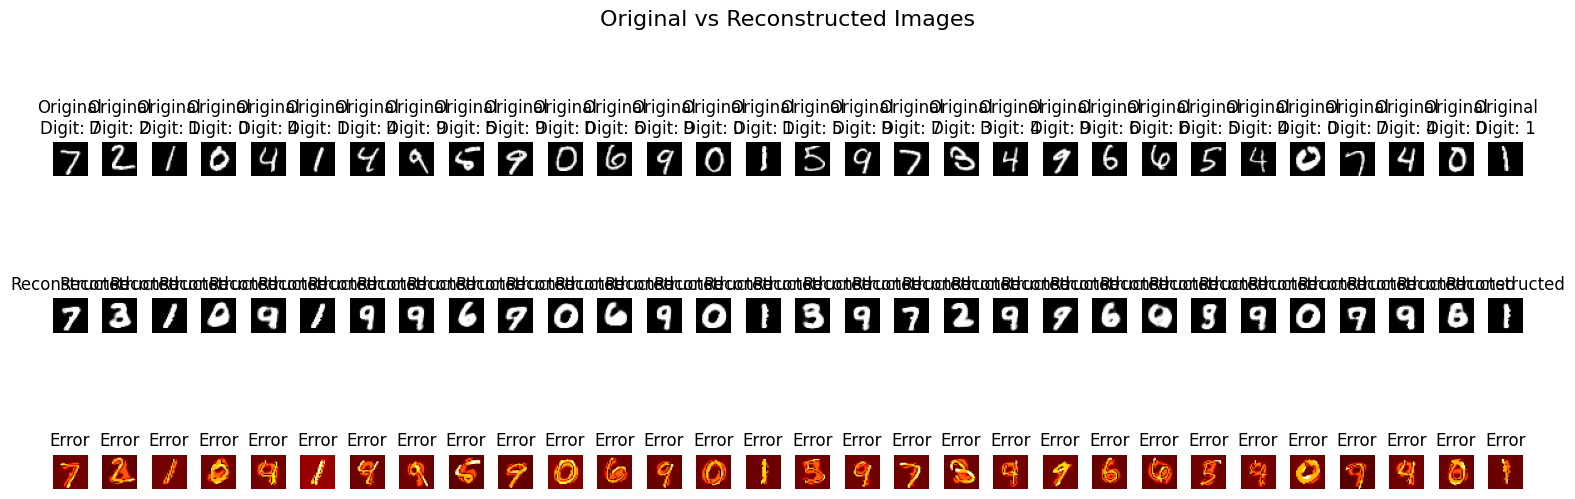

Reconstruction Quality Metrics:
MSE: 0.640847
PSNR: 1.93 dB


In [19]:
# def visualize_reconstructions(model, test_loader, device, num_samples=10):
num_samples = 30
"""Visualize original images and their reconstructions"""
model.eval()

# Get a batch of test images
data, labels = next(iter(test_loader))
data = data[:num_samples].to(device)
labels = labels[:num_samples]

with torch.no_grad():
    # reconstructions, latent, lc = model(data)
    e = model.encode(data)
    e_s = torch.sigmoid(e)
    # q is copy of e_s
    q = e_s.clone()
    q[e_s > 0.5] = 1.0
    q[e_s <= 0.5] = 0.0
    reconstructions = model.decode(q)

    
    # Reshape reconstructions back to image format
    reconstructions = reconstructions.view(-1, 1, 28, 28)

# Move to CPU for plotting
originals = data.cpu()
reconstructions = reconstructions.cpu()

# Create comparison plot
fig, axes = plt.subplots(3, num_samples, figsize=(15, 6))

for i in range(num_samples):
    # Original images
    axes[0, i].imshow(originals[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f'Original\nDigit: {labels[i]}')
    axes[0, i].axis('off')
    
    # Reconstructed images
    axes[1, i].imshow(reconstructions[i].squeeze(), cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')
    
    # Difference (error)
    diff = torch.abs(originals[i] - reconstructions[i])
    axes[2, i].imshow(diff.squeeze(), cmap='hot')
    axes[2, i].set_title('Error')
    axes[2, i].axis('off')

plt.suptitle('Original vs Reconstructed Images', fontsize=16)
plt.tight_layout()
plt.show()

# Calculate and print reconstruction quality metrics
mse = F.mse_loss(reconstructions, originals)
psnr = 10 * torch.log10(1.0 / mse)

print(f"Reconstruction Quality Metrics:")
print(f"MSE: {mse:.6f}")
print(f"PSNR: {psnr:.2f} dB")

# Visualize reconstructions
# visualize_reconstructions(model, test_loader, device)

In [18]:
q[2]

tensor([0., 0., 1., 0., 1., 1., 1., 1.], device='cuda:0')

Latent space analysis with 1000 samples
Latent dimension: 8
Latent mean range: [0.432, 0.697]
Latent std range: [0.460, 0.500]


/tmp/ipykernel_1523799/346196279.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([all_latents[all_labels == i, :5].numpy().flatten()
/tmp/ipykernel_1523799/346196279.py:79: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[1, 1].scatter([], [], c=plt.cm.tab10(i), label=str(i), s=50)


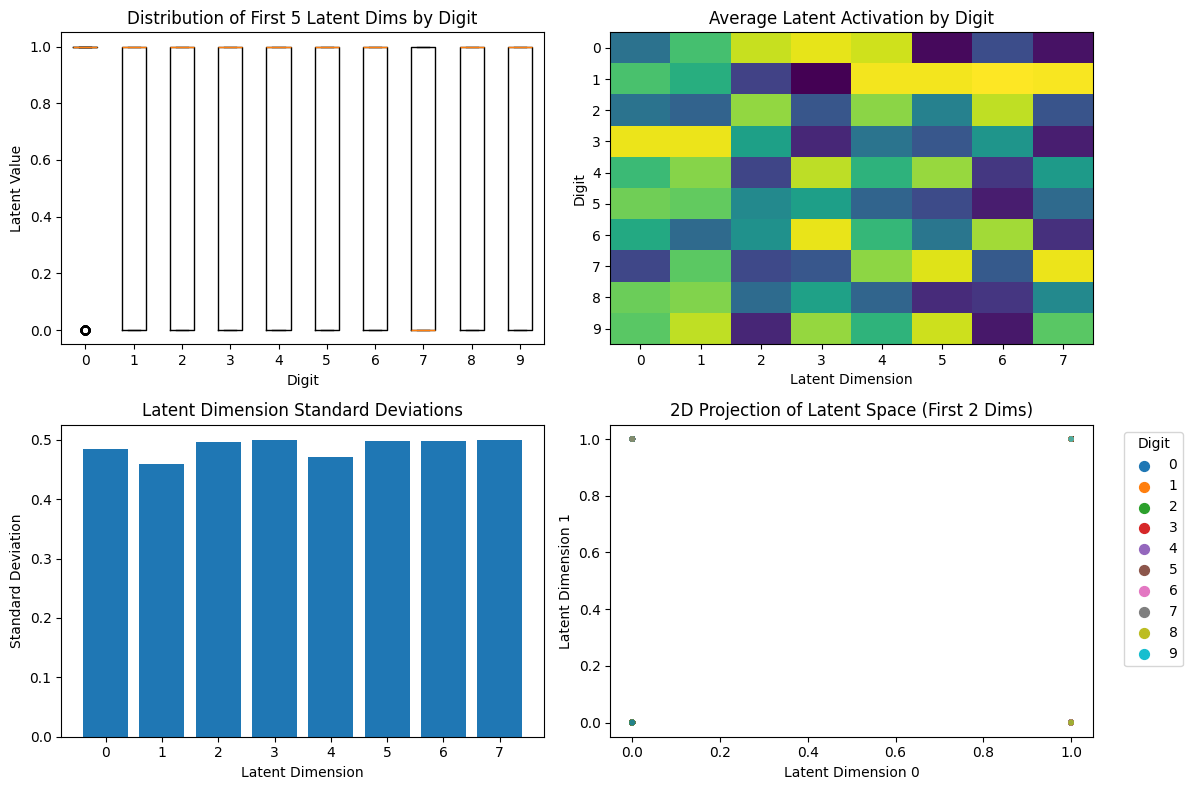

In [11]:
def analyze_latent_space(model, test_loader, device, num_samples=1000):
    """Analyze the learned latent space"""
    model.eval()
    
    latents = []
    labels_list = []
    
    with torch.no_grad():
        sample_count = 0
        for data, labels in test_loader:
            if sample_count >= num_samples:
                break
                
            data = data.to(device)
            _, latent, lc = model(data)
            
            latents.append(latent.cpu())
            labels_list.append(labels)
            
            sample_count += data.size(0)
    
    # Combine all latents and labels
    all_latents = torch.cat(latents, dim=0)[:num_samples]
    all_labels = torch.cat(labels_list, dim=0)[:num_samples]
    
    print(f"Latent space analysis with {all_latents.shape[0]} samples")
    print(f"Latent dimension: {all_latents.shape[1]}")
    
    # Compute statistics
    latent_mean = all_latents.mean(dim=0)
    latent_std = all_latents.std(dim=0)
    
    print(f"Latent mean range: [{latent_mean.min():.3f}, {latent_mean.max():.3f}]")
    print(f"Latent std range: [{latent_std.min():.3f}, {latent_std.max():.3f}]")
    
    # Plot latent space statistics
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Latent means by digit
    means_by_digit = []
    for digit in range(10):
        digit_mask = all_labels == digit
        digit_latents = all_latents[digit_mask]
        if len(digit_latents) > 0:
            means_by_digit.append(digit_latents.mean(dim=0))
    
    means_by_digit = torch.stack(means_by_digit)
    
    # Plot 1: First few latent dimensions by digit
    axes[0, 0].boxplot([all_latents[all_labels == i, :5].numpy().flatten() 
                       for i in range(10)], labels=range(10))
    axes[0, 0].set_title('Distribution of First 5 Latent Dims by Digit')
    axes[0, 0].set_xlabel('Digit')
    axes[0, 0].set_ylabel('Latent Value')
    
    # Plot 2: Latent dimension activation patterns
    axes[0, 1].imshow(means_by_digit.numpy(), aspect='auto', cmap='viridis')
    axes[0, 1].set_title('Average Latent Activation by Digit')
    axes[0, 1].set_xlabel('Latent Dimension')
    axes[0, 1].set_ylabel('Digit')
    axes[0, 1].set_yticks(range(10))
    
    # Plot 3: Latent space variance
    axes[1, 0].bar(range(len(latent_std)), latent_std.numpy())
    axes[1, 0].set_title('Latent Dimension Standard Deviations')
    axes[1, 0].set_xlabel('Latent Dimension')
    axes[1, 0].set_ylabel('Standard Deviation')
    
    # Plot 4: 2D projection using first two dimensions
    colors = plt.cm.tab10(all_labels.numpy())
    scatter = axes[1, 1].scatter(all_latents[:, 0], all_latents[:, 1], 
                               c=colors, alpha=0.6, s=10)
    axes[1, 1].set_title('2D Projection of Latent Space (First 2 Dims)')
    axes[1, 1].set_xlabel('Latent Dimension 0')
    axes[1, 1].set_ylabel('Latent Dimension 1')
    
    # Add legend for digits
    for i in range(10):
        axes[1, 1].scatter([], [], c=plt.cm.tab10(i), label=str(i), s=50)
    axes[1, 1].legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return all_latents, all_labels

# Analyze latent space
latents, labels = analyze_latent_space(model, test_loader, device)

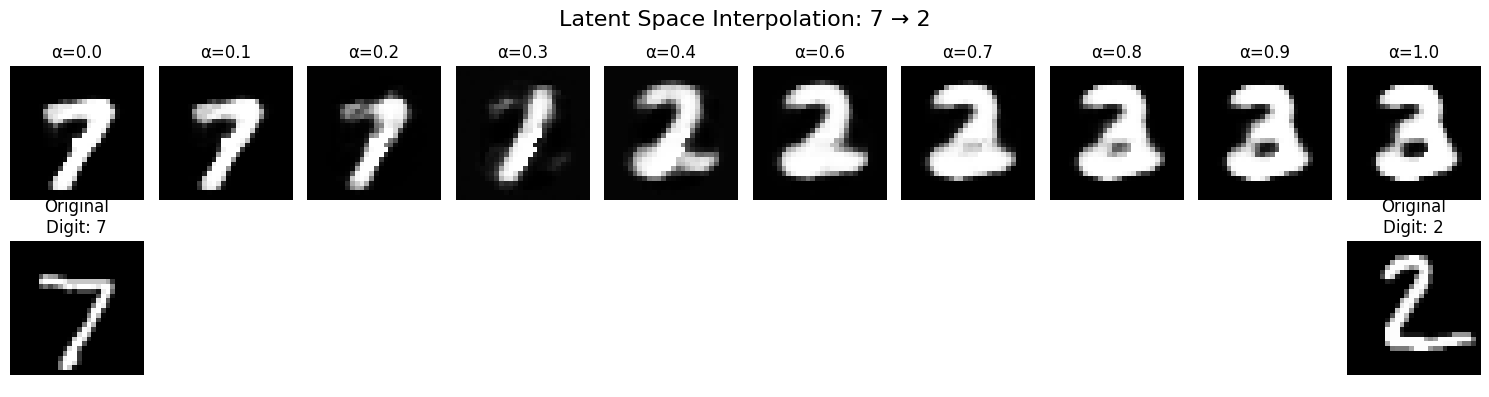

In [12]:
def interpolate_in_latent_space(model, test_loader, device, steps=10):
    """Interpolate between two images in latent space"""
    model.eval()
    
    # Get two different digits
    data, labels = next(iter(test_loader))
    
    # Find two images of different digits
    img1_idx = 0
    img2_idx = 1
    while labels[img1_idx] == labels[img2_idx]:
        img2_idx += 1
        if img2_idx >= len(labels):
            break
    
    img1 = data[img1_idx:img1_idx+1].to(device)
    img2 = data[img2_idx:img2_idx+1].to(device)
    
    with torch.no_grad():
        # Encode both images
        _, z1, lc = model(img1)
        _, z2, lc = model(img2)
        
        # Create interpolation
        interpolated_images = []
        alphas = []
        
        for i in range(steps):
            alpha = i / (steps - 1)
            alphas.append(alpha)
            
            # Linear interpolation in latent space
            z_interp = (1 - alpha) * z1 + alpha * z2
            
            # Decode interpolated latent
            img_interp = model.decode(z_interp)
            img_interp = img_interp.view(1, 28, 28)
            interpolated_images.append(img_interp.cpu().squeeze())
    
    # Visualize interpolation
    fig, axes = plt.subplots(2, steps, figsize=(15, 4))
    
    # Top row: interpolated images
    for i, img in enumerate(interpolated_images):
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'α={alphas[i]:.1f}')
        axes[0, i].axis('off')
    
    # Bottom row: show original images for reference
    axes[1, 0].imshow(img1.cpu().squeeze(), cmap='gray')
    axes[1, 0].set_title(f'Original\nDigit: {labels[img1_idx]}')
    axes[1, 0].axis('off')
    
    axes[1, -1].imshow(img2.cpu().squeeze(), cmap='gray')
    axes[1, -1].set_title(f'Original\nDigit: {labels[img2_idx]}')
    axes[1, -1].axis('off')
    
    # Hide middle axes in bottom row
    for i in range(1, steps-1):
        axes[1, i].axis('off')
    
    plt.suptitle(f'Latent Space Interpolation: {labels[img1_idx]} → {labels[img2_idx]}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Perform latent space interpolation
interpolate_in_latent_space(model, test_loader, device)

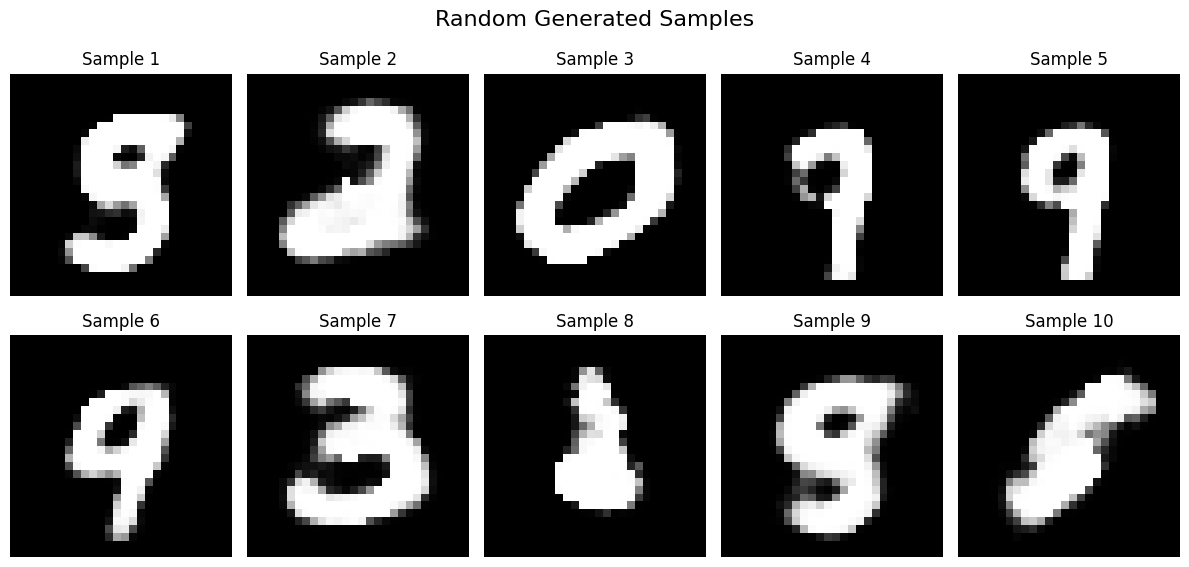

Model saved as 'linear_autoencoder_mnist.pth'


In [ ]:
def generate_random_samples(model, device, num_samples=10):
    """Generate random samples by sampling from the latent space"""
    model.eval()
    
    with torch.no_grad():
        # Sample random latent vectors from a normal distribution
        # Based on the statistics of the learned latent space
        random_latents = torch.randn(num_samples, model.latent_dim).to(device)
        
        # Scale to match the learned latent space distribution
        random_latents = random_latents * 2.0  # Adjust scaling as needed
        
        # Decode to generate images
        generated_images = model.decode(random_latents)
        generated_images = generated_images.view(num_samples, 28, 28)
    
    # Visualize generated samples
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            ax.imshow(generated_images[i].cpu(), cmap='gray')
            ax.set_title(f'Sample {i+1}')
        ax.axis('off')
    
    plt.suptitle('Random Generated Samples', fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate random samples
generate_random_samples(model, device)

# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'model_config': {
        'input_dim': 784,
        'hidden_dims': [512, 256, 128],
        'latent_dim': 32
    }
}, 'linear_autoencoder_mnist.pth')

print("Model saved as 'linear_autoencoder_mnist.pth'")

In [ ]:
def analyze_compression_performance(model, test_loader, device):
    """Analyze the compression performance of the autoencoder"""
    model.eval()
    
    # Calculate compression metrics
    original_size = 784  # 28*28 pixels
    compressed_size = model.latent_dim
    compression_ratio = original_size / compressed_size
    
    print("Compression Analysis:")
    print("-" * 50)
    print(f"Original image size: {original_size} values (28×28)")
    print(f"Compressed representation: {compressed_size} values")
    print(f"Compression ratio: {compression_ratio:.1f}:1")
    print(f"Size reduction: {(1 - compressed_size/original_size)*100:.1f}%")
    
    # Calculate reconstruction quality on test set
    total_mse = 0
    total_samples = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_data, _, lc = model(data)
            
            # Flatten for comparison
            data_flat = data.view(data.size(0), -1)
            
            mse = F.mse_loss(recon_data, data_flat, reduction='sum')
            total_mse += mse.item()
            total_samples += data.size(0)
    
    avg_mse = total_mse / total_samples
    avg_psnr = 10 * np.log10(1.0 / avg_mse) if avg_mse > 0 else float('inf')
    
    print(f"\nReconstruction Quality:")
    print(f"Average MSE: {avg_mse:.6f}")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    
    return {
        'compression_ratio': compression_ratio,
        'mse': avg_mse,
        'psnr': avg_psnr
    }

# Analyze compression performance
compression_stats = analyze_compression_performance(model, test_loader, device)

Compression Analysis:
--------------------------------------------------
Original image size: 784 values (28×28)
Compressed representation: 32 values
Compression ratio: 24.5:1
Size reduction: 95.9%

Reconstruction Quality:
Average MSE: 495.637585
Average PSNR: -26.95 dB

Reconstruction Quality:
Average MSE: 495.637585
Average PSNR: -26.95 dB
